In [1]:

## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 0
__N_FOLDS = 5
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
import time

font = {'size'   : 10}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch_utils.seed_everything(__SEED)

fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)

In [3]:
train = pd.read_csv("./train.csv", index_col="id", nrows=__NROWS)
test = pd.read_csv("./test.csv", index_col="id", nrows=__NROWS)
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [4]:

# contingency table should be a dataframe
# cramerV is kind of correlation between two categorical variables
def calculate_cramerV(contingency_table):
    # get the chi2 value
    chi2 = scipy.stats.chi2_contingency(contingency_table)[0]
    # count total values in the table
    n = contingency_table.sum().sum()
    # get the number of rows and columns in the table
    r,c = contingency_table.shape
    # calculate cramerV
    cramerV = np.sqrt(chi2/(n*min(r-1, c-1)))
    
    return cramerV

def summarize_categorical(train, test, use_feat=[], exclude_feat=[], target_for_cramerV=None):
    """
    train: train dataframe
    test: test dataframe
    
    use_feat: list of features for which statistics will be calculated, if empty, uses all columns except the ones in exclue_feat
    exclue_feat: features to be exclueded from the statistics calculation
    
    target_for_cramerV: target column label for cramerV calculation

    """
    
    
    all_stats = []
    
    if len(use_feat)==0:
        use_feat = [c for c in list(train.columns) if c not in exclude_feat]
    
    for col in tqdm(use_feat):
        vcTrain = dict(train[col].value_counts())
        vcTest = dict(test[col].value_counts())
        
        set_train_only_vals = set(vcTrain.keys())-set(vcTest.keys())
        set_test_only_vals = set(vcTest.keys())-set(vcTrain.keys())
        
        dict_train_only_vals = {k:v for k,v in vcTrain.items() if k in set_train_only_vals}
        dict_test_only_vals = {k:v for k,v in vcTest.items() if k in set_test_only_vals}
        
        trainUniqueVals, trainTotalVals = len(vcTrain), pd.Series(vcTrain).sum()
        trainOnlyUniqueVals, trainOnlyTotalVals = len(dict_train_only_vals), pd.Series(dict_train_only_vals).sum()
        
        testUniqueVals, testTotalVals = len(vcTest), pd.Series(vcTest).sum()
        testOnlyUniqueVals, testOnlyTotalVals = len(dict_test_only_vals), pd.Series(dict_test_only_vals).sum()
        
        
        if target_for_cramerV is not None:
            contingency_table = pd.crosstab(train[col], train[target_for_cramerV].fillna(-1))
            vc = calculate_cramerV(contingency_table)
        else:
            vc = -1
            
        all_stats.append((
            col, round(vc, 3), train[col].nunique(),
            test[col].nunique(),
            str(trainOnlyUniqueVals)+"("+str(round(100.0*(trainOnlyUniqueVals/trainUniqueVals),3))+")",
            str(testOnlyUniqueVals)+"("+str(round(100.0*(testOnlyUniqueVals/testUniqueVals),3))+")",
            str(train[col].isnull().sum())+"("+str(round(100.0*(train[col].isnull().sum()/train.shape[0]),3))+")",
            str(train[col].isnull().sum())+"("+str(round(100.0*(train[col].isnull().sum()/train.shape[0]),3))+")",
            str(train[col].value_counts().index[0])+"("+str(round(100.0 * train[col].value_counts(normalize = True, dropna = False).values[0], 3))+")",
            train[col].dtype
        ))
    
    
    df_stats = pd.DataFrame(all_stats,columns=[
        "Feature",
        "Target Cramer's V",
        "Unique values (Train)",
        "Unique values (Test)",
        "Train only value counts",
        "Test only value counts",
        "Missing (Train)",
        "Missing (Test)",
        "Value with the highest counts 7(Train)",
        "DataType"
    ])
    
    if target_for_cramerV is None:
        df_stats.drop(["Target Cramer's V"], axis=1, inplace=True)
        
    return df_stats, dict_train_only_vals, dict_test_only_vals

In [5]:
stats, tro, tso = summarize_categorical(train, test, exclude_feat=["target"], target_for_cramerV="target")

In [6]:
stats

,Feature,Target Cramer's V,Unique values (Train),Unique values (Test),Train only value counts,Test only value counts,Missing (Train),Missing (Test),Value with the highest counts 7(Train),DataType
0,bin_0,0.002,2,2,0(0.0),0(0.0),0(0.0),0(0.0),0(87.25),int64
1,bin_1,0.089,2,2,0(0.0),0(0.0),0(0.0),0(0.0),0(74.339),int64
2,bin_2,0.012,2,2,0(0.0),0(0.0),0(0.0),0(0.0),0(61.678),int64
3,bin_3,0.007,2,2,0(0.0),0(0.0),0(0.0),0(0.0),T(51.178),object
4,bin_4,0.046,2,2,0(0.0),0(0.0),0(0.0),0(0.0),Y(63.878),object
5,nom_0,0.098,3,3,0(0.0),0(0.0),0(0.0),0(0.0),Green(42.447),object
6,nom_1,0.070,6,6,0(0.0),0(0.0),0(0.0),0(0.0),Trapezoid(33.727),object
7,nom_2,0.067,6,6,0(0.0),0(0.0),0(0.0),0(0.0),Lion(33.765),object
8,nom_3,0.072,6,6,0(0.0),0(0.0),0(0.0),0(0.0),Russia(33.708),object
9,nom_4,0.088,4,4,0(0.0),0(0.0),0(0.0),0(0.0),Oboe(30.764),object


In [7]:
def get_color_top_n_title(feature_unique_count, feature_name, feature_type, top_n=None):
    if top_n is None:
        result = ["g", feature_unique_count]
    elif feature_unique_count > 2*top_n:
        result = ["r", top_n]
    elif feature_unique_count > top_n:
        result =["y", top_n]
    else: 
        result = ["g", top_n]
    
    title = feature_name[:20]+" ("+feature_type[:3]+"-{})".format(feature_unique_count)
    result.append(title)
    return result

def plot_multiple_categorical(df, features, col_target=None, top_n=None, 
                              n_subplots_per_row=4, hspace=1.3, wspace=0.5,
                              fig_h=15, m_fig_w=4.2, landmark=0.01, save=False):
    
    if col_target is not None:
        ref = df[col_target].mean()
        tgtFeat = df[col_target].copy()
    
    
    plt.figure()
    
    total_rows = int(np.ceil(1.0*len(features)/n_subplots_per_row))
    
    fig, ax = plt.subplots(total_rows, n_subplots_per_row, figsize=(fig_h, m_fig_w*total_rows))
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    
    for i, f in enumerate(features):
        curFeat = df[f].copy()
        curFeatDtype = curFeat.dtype.name
        
        ## Take care of the missing values
        if curFeatDtype in ["float16","float32","float64"]:
            curFeat.fillna(-1000.0, inplace=True)
        if curFeatDtype in ["object"]:
            curFeat.fillna("_NaN", inplace=True)
        if curFeatDtype == "category" and curFeat.isnull().sum() > 0:
            curFeat = curFeat.astype(str).replace('', '_NaN', regex=False).astype("category")
        
        
        ## create bar color
        bar_color, top_ns, title = get_color_top_n_title(curFeat.nunique(), f, str(curFeat.dtype.name), top_n)
        
        ## create statistics
        
        if col_target is not None:
            tmpdf = pd.DataFrame()
            tmpdf[col_target] = tgtFeat
            tmpdf[f]=curFeat
            
            stats = tmpdf.groupby([f]).agg({col_target: ['count', 'mean']})
            stats = stats.sort_values((col_target, 'count'), ascending=False).head(top_ns).sort_index()
        
            stats.index = stats.index.map(str)
            stats = stats.rename(index={'-1000.0':'NaN'})
            if top_n is not None:
                stats.index = stats.index.map(lambda x: x[:top_n])
        
            stats["ref"] = ref
            stats["ref-"] = ref-landmark
            stats["ref+"] = ref+landmark
            ax[i//n_subplots_per_row][i%n_subplots_per_row].bar(stats.index, stats[col_target]['count'], color=bar_color)
            
            xx = ax[i//n_subplots_per_row][i%n_subplots_per_row].get_xlim()
            
            ax2 = fig.add_subplot(total_rows,n_subplots_per_row, i+1, sharex=ax[i//n_subplots_per_row,i%n_subplots_per_row], frameon=False)
            ax2.plot(stats[col_target]['mean'].values, marker="x", color="b", linestyle="dashed")
            
            ax2.plot(stats["ref"].values, marker="_", color="black", linestyle="solid", linewidth=2.5)
            ax2.plot(stats["ref-"].values, marker="_", color="black",linewidth=1)
            ax2.plot(stats["ref+"].values, marker="_", color="black",linewidth=1)
            
            ax2.yaxis.tick_right()
            ax2.axes.get_xaxis().set_visible(False)
            
            ax[i//n_subplots_per_row][i%n_subplots_per_row].set_xlim(xx)
            
            
        else:
            vc = curFeat.value_counts()
            vc = vc.head(top_ns).sort_index()
            vc.index = vc.index.map(str)
            vc = vc.rename(index={"-1000.0":"NaN"})
            
            if top_n is not None:
                vc.index = vc.index.map(lambda x: x[:top_n])
            ax[i//n_subplots_per_row][i%n_subplots_per_row].bar(vc.index, vc.values, color=bar_color)
        
        ax[i//n_subplots_per_row][i%n_subplots_per_row].set_title(title, fontsize=12)
        ax[i//n_subplots_per_row][i%n_subplots_per_row].tick_params(axis="x",rotation=90)
    
    
    if(n_subplots_per_row*total_rows!=len(features)):
        for i in range(1,1+(n_subplots_per_row*total_rows)-len(features)):
            ax[-1][-i].axis("off")
    
    fig.tight_layout()
    if save:
        plt.savefig("CatPlot showing relation with target.png", bbox_inches="tight")
    else:
        plt.show()

<Figure size 432x288 with 0 Axes>

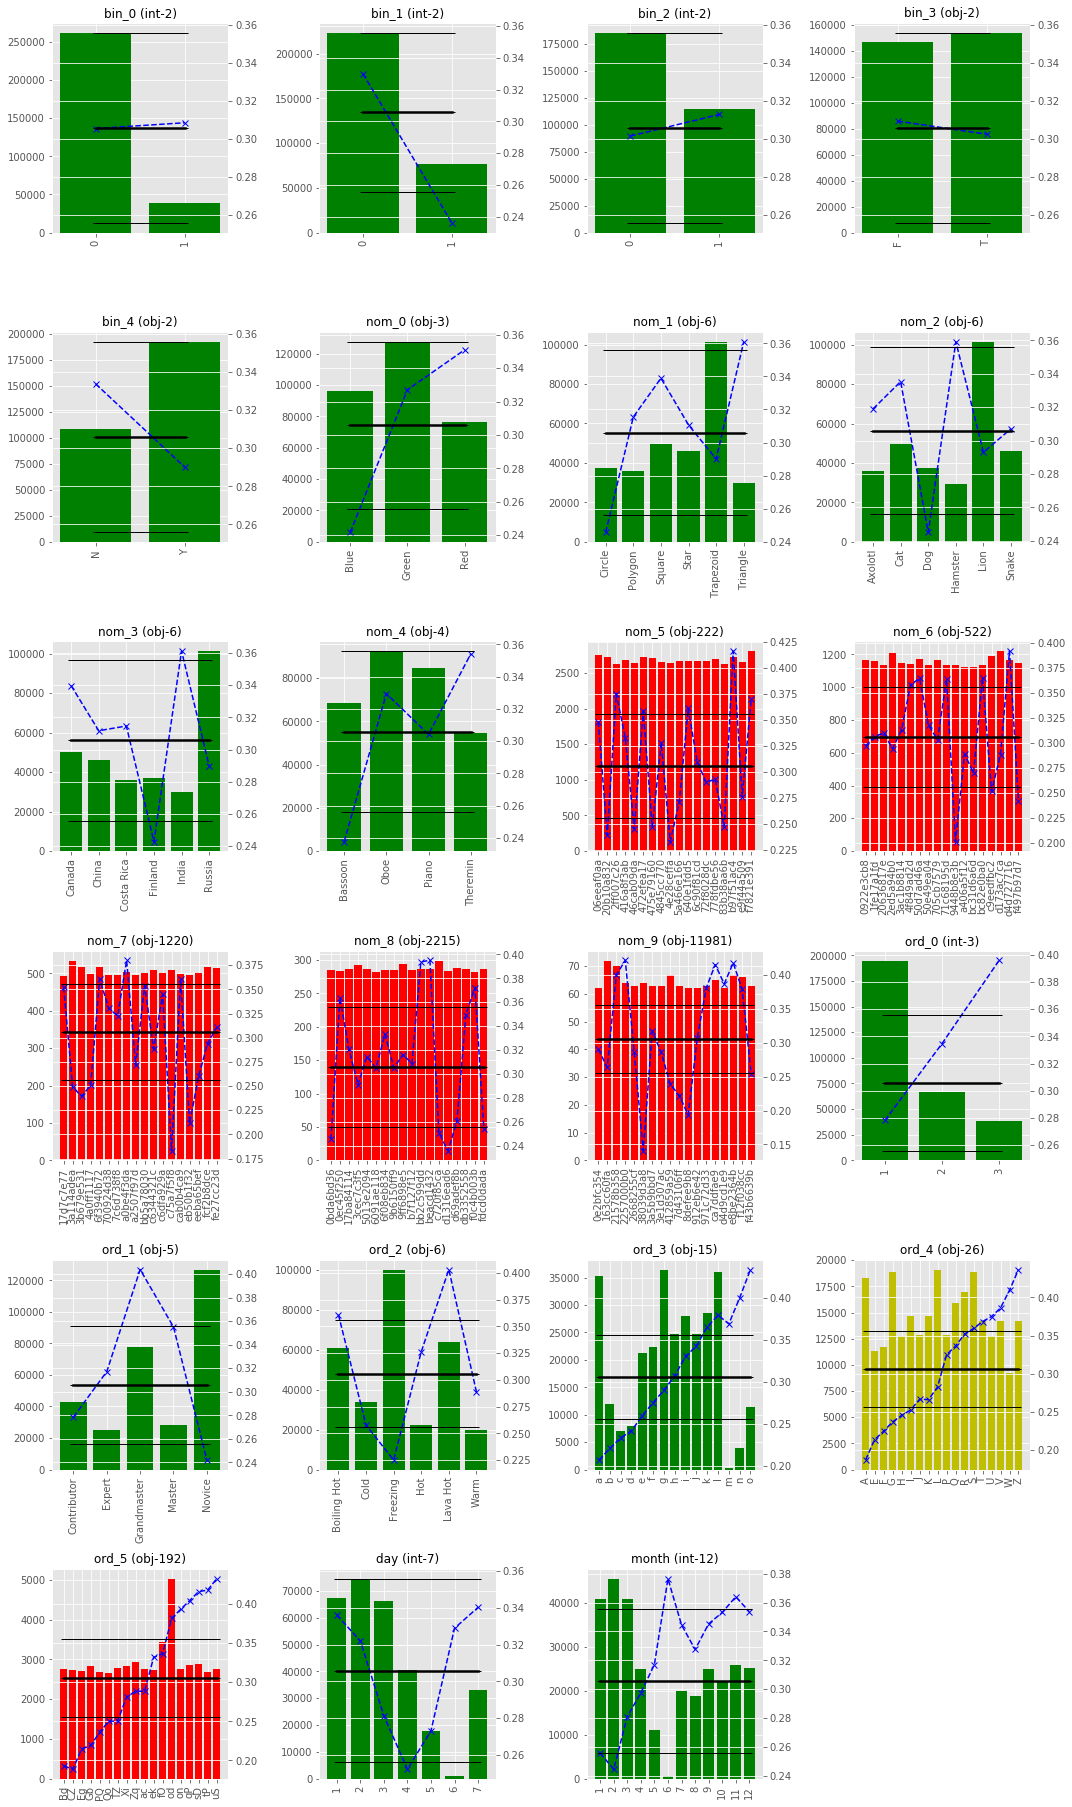

In [8]:
plot_multiple_categorical(train, [c for c in train.columns if c !="target"], col_target="target", top_n=18, landmark=0.05, save=True)

In [9]:
def cross_val_print(pipe, X, y, cv, scoring="roc_auc", best_score=0.):
    scores = ms.cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=True)
    cv_score = scores["test_score"].mean()
    train_score = scores["train_score"].mean()
    
    if cv == fold1:
        precision=1
    elif cv == fold2:
        precision=2
    elif cv == fold3:
        precision=3
        
    
    print("CV{} score on valid: {:.7f} - Previous best valid score: {:.7f} - Train mean score: {:6f}".format(precision, cv_score, best_score, train_score))
    
    if cv_score>best_score:
        best_score = cv_score
    
    return cv_score, best_score

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression

In [11]:
lr_params = {"penalty":"l2", "solver":"lbfgs","C":0.123, "max_iter":777,"verbose":1,"n_jobs":5}

In [12]:
%%time
ohe1 = (pp.OneHotEncoder(categories="auto", sparse=True, dtype="uint8",handle_unknown="ignore"),[f for f in train.columns if f not in ["target",'bin_0']])
pipe = make_pipeline(make_column_transformer(ohe1), LogisticRegression(**lr_params))
_, best1 = cross_val_print(pipe, train, train["target"], cv=fold1)
_, best2 = cross_val_print(pipe, train, train["target"], cv=fold2)
_, best3 = cross_val_print(pipe, train, train["target"], cv=fold3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.5s finished


CV1 score on valid: 0.8035653 - Previous best valid score: 0.0000000 - Train mean score: 0.829525


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.2s finished


CV2 score on valid: 0.8030586 - Previous best valid score: 0.0000000 - Train mean score: 0.829614


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.4s finished


CV3 score on valid: 0.8031846 - Previous best valid score: 0.0000000 - Train mean score: 0.829584
CPU times: user 1min 27s, sys: 6.05 s, total: 1min 33s
Wall time: 3min 36s


In [13]:
%%time
ohe1 = (pp.OneHotEncoder(categories="auto", sparse=True, dtype="uint8",handle_unknown="ignore"),[f for f in train.columns if f not in ["target"]])
pipe = make_pipeline(make_column_transformer(ohe1), LogisticRegression(**lr_params))
_, best01 = cross_val_print(pipe, train, train["target"], cv=fold1, best_score=best1)
_, best02 = cross_val_print(pipe, train, train["target"], cv=fold2, best_score=best2)
_, best03 = cross_val_print(pipe, train, train["target"], cv=fold3, best_score=best3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.4s finished


CV1 score on valid: 0.8035591 - Previous best valid score: 0.8035653 - Train mean score: 0.829520


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.8s finished


CV2 score on valid: 0.8030557 - Previous best valid score: 0.8030586 - Train mean score: 0.829604


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.6s finished


CV3 score on valid: 0.8031780 - Previous best valid score: 0.8031846 - Train mean score: 0.829582
CPU times: user 1min 28s, sys: 6.47 s, total: 1min 34s
Wall time: 3min 47s


In [14]:
best1, best2, best3

(0.8035652986946799, 0.8030585677007936, 0.803184647431005)

In [15]:
best01, best02, best03

(0.8035652986946799, 0.8030585677007936, 0.803184647431005)

In [16]:
for df in [train, test]:
    df["bin_0_bin_3"] = df["bin_3"].astype(str)+df["bin_0"].astype(str)

In [17]:
ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), [f for f in train.columns if f not in ["target","bin_0", "bin_3"]])
pipe = make_pipeline(make_column_transformer(ohe1), LogisticRegression(**lr_params))
_,best11 = cross_val_print(pipe, train, train["target"], cv=fold1, best_score=best1)
_,best12 = cross_val_print(pipe, train, train["target"], cv=fold2, best_score=best2)
_,best13 = cross_val_print(pipe, train, train["target"], cv=fold3, best_score=best3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.9s finished


CV1 score on valid: 0.8035763 - Previous best valid score: 0.8035653 - Train mean score: 0.829540


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   10.9s finished


CV2 score on valid: 0.8030657 - Previous best valid score: 0.8030586 - Train mean score: 0.829625


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   10.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.5s finished


CV3 score on valid: 0.8031857 - Previous best valid score: 0.8031846 - Train mean score: 0.829596


<Figure size 432x288 with 0 Axes>

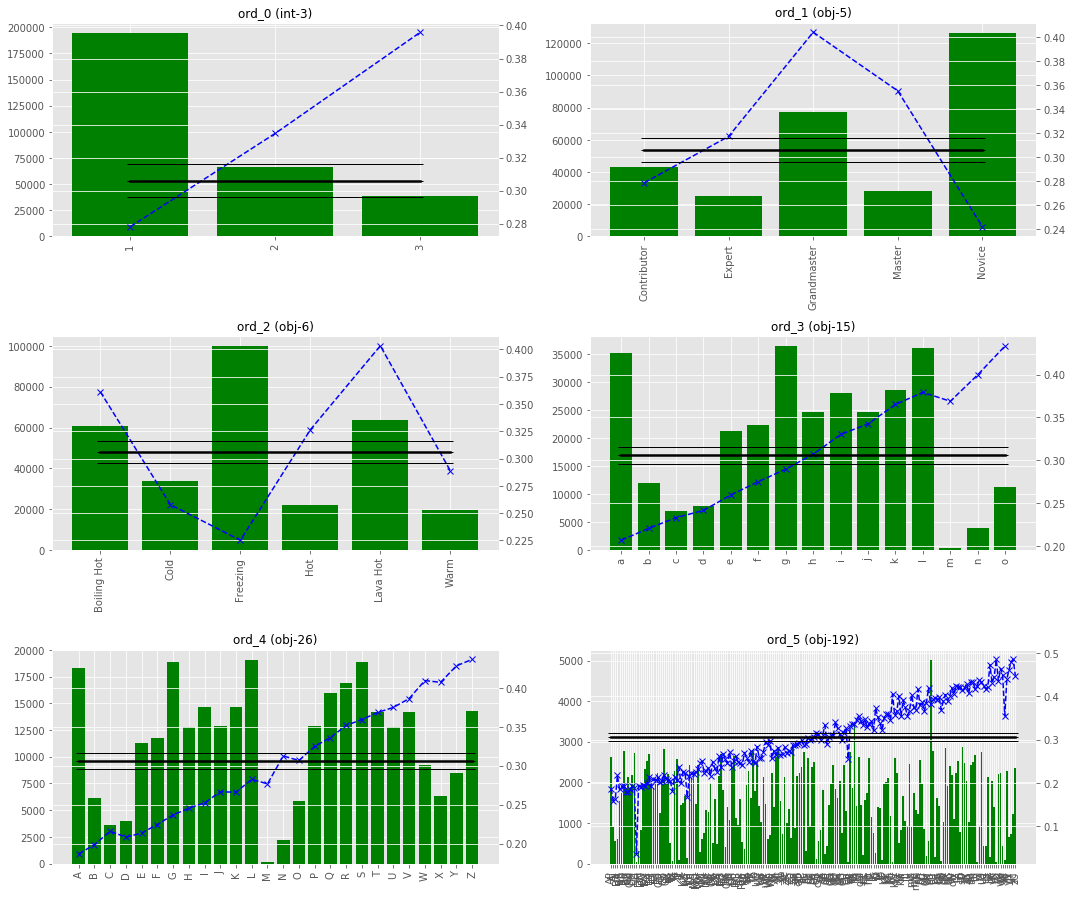

In [18]:
plot_multiple_categorical(train, ["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5"],col_target="target", n_subplots_per_row=2)

In [19]:
from string import ascii_lowercase

In [20]:
def transform_feat(srs):
    transform_dict = {
        "ord_1":{"Novice":0,"Contributor":1,"Expert":2, "Master":3, "Grandmaster":4},
        "ord_2":{"Freezing":0,"Cold":1,"Warm":2, "Hot":3, "Boiling Hot":4,"Lava Hot":5},
        "nom_0":{"Blue":1,"Green":2, "Red":3},
        "nom_1":{"Circle":1,"Trapezoid":2, "Star":3,"Polygon":4,"Square":5,"Triangle":6},
        "nom_2":{"Dog":1,"Lion":2, "Snake":3,"Axolotl":4,"Cat":5,"Hamster":6},
        "nom_3":{"Finland":1,"Russia":2, "China":3,"Costa Rica":4,"Canada":5,"India":6},
        "nom_4":{"Bassoon":1,"Piano":2, "Oboe":3,"Theremin":4}   
    }
    
    if srs.name == "ord_0":
        return srs-1
    elif srs.name == "ord_5":
        vals = list(np.sort(srs.unique()))
        return srs.map({l:i for i, l in enumerate(vals)})
    elif srs.name in ["ord_3", "ord_4"]:
        return srs.str.lower().map({l:i for i, l in enumerate(list(ascii_lowercase))})
    elif srs.name in transform_dict.keys():
        return srs.map(transform_dict[srs.name])
    else:
        return srs

<Figure size 432x288 with 0 Axes>

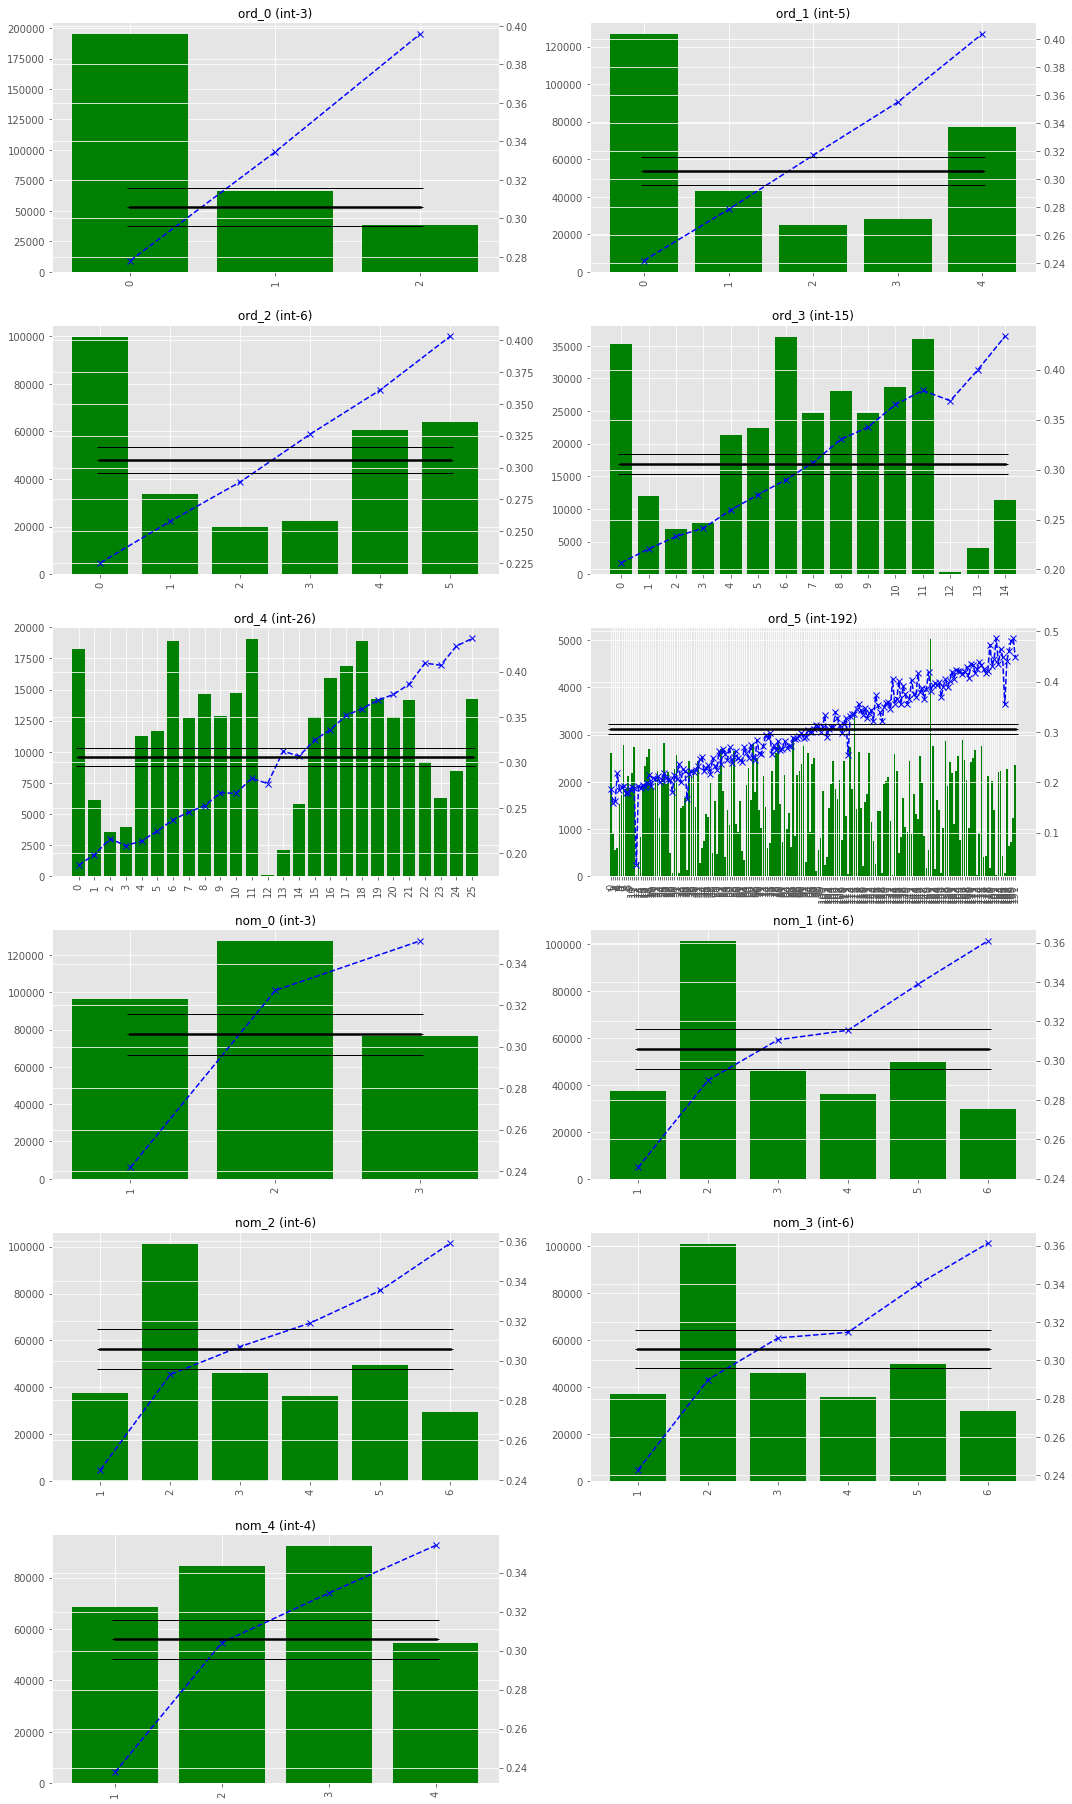

In [21]:
df = train.copy()
for f in df.columns:
    df[f] = transform_feat(df[f])

plot_multiple_categorical(df,["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5","nom_0","nom_1","nom_2","nom_3", "nom_4"],col_target="target", n_subplots_per_row=2)

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_features=[]):
        self.ordinal_features = ordinal_features
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for v in self.ordinal_features:
            df[v] = transform_feat(df[v])
        return df

In [23]:
ohe_feat = ["bin_0_bin_3","bin_1", "bin_2","bin_4", "nom_0", "nom_1", "nom_2", "nom_3", "nom_4", "nom_5", "nom_6", "nom_7", "nom_8", "nom_9", "day", "month"]
ord_feat = ["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5"]

for f in ord_feat:
    # treat all ordinal feature as onehot feature, except f
    ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), list(set(ohe_feat+ord_feat)-{f}))
    
    # ordinal encoding
    fe = FeatureEngineering([f])
    # normalize the ordinal encoded features
    sc = (pp.StandardScaler(copy=False), [f])
    
    pipe = make_pipeline(fe, make_column_transformer(ohe1, sc), LogisticRegression(**lr_params))
    
    print("Treating only {} as Ordinal Feature".format(f))
    _,_ = cross_val_print(pipe, train, train["target"], cv=fold1, best_score=best11)

Treating only ord_0 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished


CV1 score on valid: 0.8035773 - Previous best valid score: 0.8035763 - Train mean score: 0.829534
Treating only ord_1 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.1s finished


CV1 score on valid: 0.8035859 - Previous best valid score: 0.8035763 - Train mean score: 0.829528
Treating only ord_2 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.0s finished


CV1 score on valid: 0.8035819 - Previous best valid score: 0.8035763 - Train mean score: 0.829531
Treating only ord_3 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.5s finished


CV1 score on valid: 0.8036103 - Previous best valid score: 0.8035763 - Train mean score: 0.829506
Treating only ord_4 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.6s finished


CV1 score on valid: 0.8036150 - Previous best valid score: 0.8035763 - Train mean score: 0.829457
Treating only ord_5 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.3s finished


CV1 score on valid: 0.8040323 - Previous best valid score: 0.8035763 - Train mean score: 0.829096


In [24]:
f = "ord_0"
# treat all ordinal feature as onehot feature, except f
ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), list(set(ohe_feat+ord_feat)-{f}))

# ordinal encoding
fe = FeatureEngineering([f])
# normalize the ordinal encoded features
sc = (pp.StandardScaler(copy=False), [f])

pipe = make_pipeline(fe, make_column_transformer(ohe1, sc), LogisticRegression(**lr_params))

print("Treating only {} as Ordinal Feature".format(f))
_,_ = cross_val_print(pipe, train, train["target"], cv=fold2, best_score=best12)
_,_ = cross_val_print(pipe, train, train["target"], cv=fold3, best_score=best13)

Treating only ord_0 as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished


CV2 score on valid: 0.8030684 - Previous best valid score: 0.8030657 - Train mean score: 0.829618


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished


CV3 score on valid: 0.8031910 - Previous best valid score: 0.8031857 - Train mean score: 0.829588


In [25]:
%%time
ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), list(set(ohe_feat)))

# ordinal encoding
fe = FeatureEngineering(ord_feat)
# normalize the ordinal encoded features
sc = (pp.StandardScaler(copy=False), ord_feat)

pipe = make_pipeline(fe, make_column_transformer(ohe1, sc), LogisticRegression(**lr_params))

print("Treating all ord_* as Ordinal Feature")
_,best1 = cross_val_print(pipe, train, train["target"], cv=fold1, best_score=best11)
_,best2 = cross_val_print(pipe, train, train["target"], cv=fold2, best_score=best12)
_,best3 = cross_val_print(pipe, train, train["target"], cv=fold3, best_score=best13)

Treating all ord_* as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.2s finished


CV1 score on valid: 0.8041184 - Previous best valid score: 0.8035763 - Train mean score: 0.828975


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.1s finished


CV2 score on valid: 0.8035877 - Previous best valid score: 0.8030657 - Train mean score: 0.829058


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.3s finished


CV3 score on valid: 0.8036835 - Previous best valid score: 0.8031857 - Train mean score: 0.829039
CPU times: user 3min 4s, sys: 10.7 s, total: 3min 15s
Wall time: 4min 26s


<Figure size 432x288 with 0 Axes>

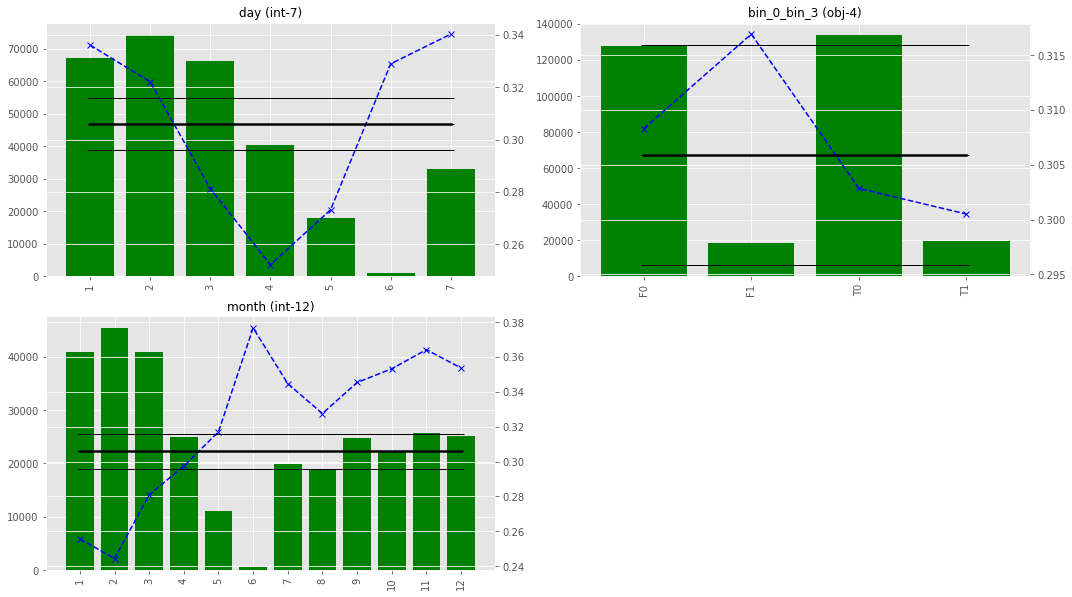

In [26]:
plot_multiple_categorical(train,["day","bin_0_bin_3","month"],"target", n_subplots_per_row=2)

<Figure size 432x288 with 0 Axes>

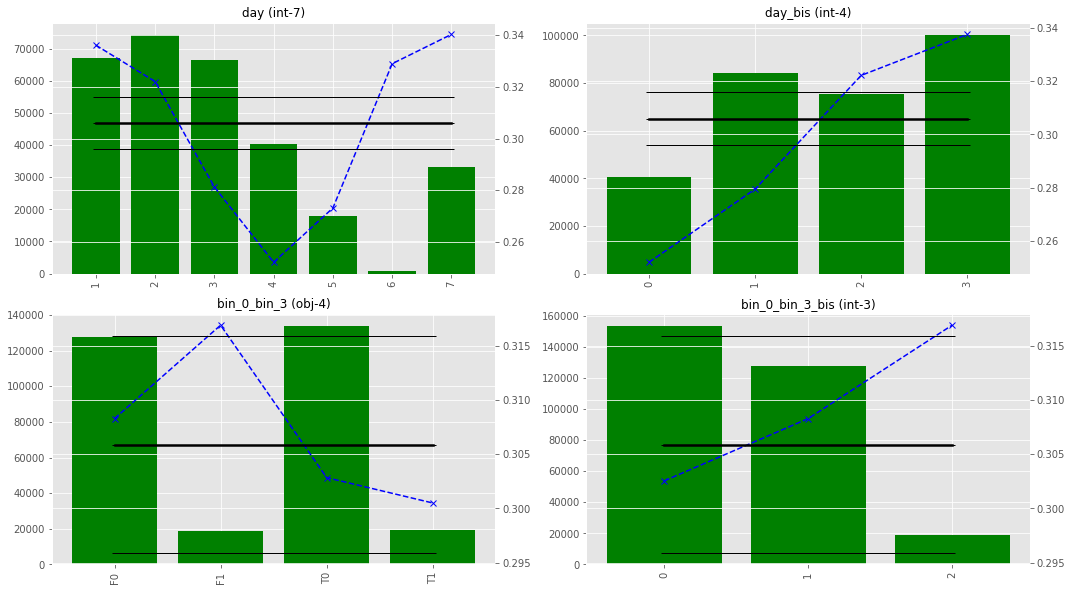

In [27]:
for df in [train, test]:
    df["day_bis"]=df["day"].map({1:3, 2:2, 3:1, 4:0, 5:1, 6:2,7:3})
    df["bin_0_bin_3_bis"] = df["bin_0_bin_3"].map({"F0":1, "F1":2, "T0":0, "T1":0})
plot_multiple_categorical(train, ["day", "day_bis", "bin_0_bin_3","bin_0_bin_3_bis"], "target", n_subplots_per_row=2)

In [69]:
%%time
ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), list(set(ohe_feat)-{"day"})+["day_bis"])

# ordinal encoding
fe = FeatureEngineering(ord_feat)
# normalize the ordinal encoded features
sc = (pp.StandardScaler(copy=False), ord_feat)

pipe = make_pipeline(fe, make_column_transformer(ohe1, sc), LogisticRegression(**lr_params))

print("Treating all ord_* as Ordinal Feature")
_,best1 = cross_val_print(pipe, train, train["target"], cv=fold1, best_score=best1)
_,best2 = cross_val_print(pipe, train, train["target"], cv=fold2, best_score=best2)
_,best3 = cross_val_print(pipe, train, train["target"], cv=fold3, best_score=best3)

print(best1, best2, best3)

Treating all ord_* as Ordinal Feature


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished


CV1 score on valid: 0.8041266 - Previous best valid score: 0.8041271 - Train mean score: 0.828972


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished


CV2 score on valid: 0.8035940 - Previous best valid score: 0.8041271 - Train mean score: 0.829063


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished


CV3 score on valid: 0.8036885 - Previous best valid score: 0.8041268 - Train mean score: 0.829033
0.804127120485562 0.804127120485562 0.8041268473026284
CPU times: user 3min 6s, sys: 11.9 s, total: 3min 18s
Wall time: 4min 49s


In [70]:
class BinsEncoder(BaseEstimator, TransformerMixin):
    """
        Binning high cardinality categorical values.
        
    """
    def __init__(self, nbins=200, nmin=20):
        self.nbins = nbins
        self.nmin = nmin
    
    def fit(self, X, y=None):
        tmp = pd.concat([X,y], axis=1)
        
        averages = tmp.groupby(by=X.name)[y.name].mean()
        means_for_each_vals = dict(zip(averages.index.values, averages.values))
        bins = np.linspace(averages.min(), averages.max(), self.nbins)
        self.map_ = dict(zip(averages.index.values, np.digitize(averages.values, bins=bins)))
        
        ## If some key has more than nmin observations, keep the original key, otherwise bin the key
        count = tmp.groupby(by=X.name)[y.name].count()
        count_for_each_vals = dict(zip(count.index.values, count.values))
        
        for key, val in count_for_each_vals.items():
            if val>self.nmin:
                self.map_[key]=key
            
        return self
    
    def transform(self, X, y=None):
        tmp = X.map(self.map_)
        tmp.fillna(random.choice(list(self.map_.values())), inplace=True)
        tmp = tmp.astype(str)
        return tmp
tst = BinsEncoder(nbins=4, nmin=10000000)
tst.fit(train["day"], train["target"])
tst.transform(train["day"]).value_counts(dropna=False)

3    142371
1    124578
4     33051
Name: day, dtype: int64

In [71]:
class FEUpgraded(BaseEstimator, TransformerMixin):
    def __init__(self, list_ordinal_features=[], feat_to_bins_encode={}):
        self.list_ordinal_features = list_ordinal_features
        self.feat_to_bins_encode = feat_to_bins_encode
        self.BinsEncoder = {}
    
    def fit(self, X, y=None):
        for feat, val in self.feat_to_bins_encode.items():
            self.BinsEncoder[feat] = BinsEncoder(nbins=val[0], nmin=val[1])
            self.BinsEncoder[feat].fit(X[feat], y)
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for v in self.feat_to_bins_encode.keys():
            df[v] = self.BinsEncoder[v].transform(df[v])
            
        for v in self.list_ordinal_features:
            df[v] = transform_feat(df[v])
        
        return df

In [72]:
ord_feat = ["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5"]
ohe_feat = ["bin_0_bin_3","bin_1","bin_2","bin_4","nom_0","nom_1","nom_2",
            "nom_3","nom_4","nom_5","nom_6","nom_7","nom_8","nom_9","day_bis","month"]

In [73]:
%%time
# BINNING nom_5 only
for nbins in [[20, 35]]:
    ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), ohe_feat)
    Fe = FEUpgraded(ord_feat, {"nom_5":nbins})
    stdscale = (pp.StandardScaler(copy=False),ord_feat)
    
    pipe = make_pipeline(Fe, make_column_transformer(ohe1, stdscale), LogisticRegression(**lr_params))
    
    print("BINNING ONLY nom_5:")
    _, best1 = cross_val_print(pipe,train, train["target"],fold1, best_score=best1)
    _, best2 = cross_val_print(pipe,train, train["target"],fold2, best_score=best2)
    _, best3 = cross_val_print(pipe,train, train["target"],fold3, best_score=best3)

BINNING ONLY nom_5:


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished


CV1 score on valid: 0.8041268 - Previous best valid score: 0.8041271 - Train mean score: 0.828974


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished


CV2 score on valid: 0.8035939 - Previous best valid score: 0.8041271 - Train mean score: 0.829054


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished


CV3 score on valid: 0.8036892 - Previous best valid score: 0.8041268 - Train mean score: 0.829046
CPU times: user 3min 9s, sys: 11.8 s, total: 3min 21s
Wall time: 4min 43s


In [74]:
%%time
# BINNING nom_6 only
for nbins in [[20, 5]]:
    ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), ohe_feat)
    Fe = FEUpgraded(ord_feat, {"nom_6":nbins})
    stdscale = (pp.StandardScaler(copy=False),ord_feat)
    
    pipe = make_pipeline(Fe, make_column_transformer(ohe1, stdscale), LogisticRegression(**lr_params))
    
    print("BINNING ONLY nom_6:")
    _, best1 = cross_val_print(pipe,train, train["target"],fold1, best_score=best1)
    _, best2 = cross_val_print(pipe,train, train["target"],fold2, best_score=best2)
    _, best3 = cross_val_print(pipe,train, train["target"],fold3, best_score=best3)

BINNING ONLY nom_6:


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished


CV1 score on valid: 0.8041271 - Previous best valid score: 0.8041271 - Train mean score: 0.828970


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished


CV2 score on valid: 0.8035936 - Previous best valid score: 0.8041271 - Train mean score: 0.829058


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished


CV3 score on valid: 0.8036883 - Previous best valid score: 0.8041268 - Train mean score: 0.829044
CPU times: user 3min 9s, sys: 12.2 s, total: 3min 21s
Wall time: 4min 27s


In [75]:
%%time
# BINNING nom_7 only
for nbins in [[15,3]]:
    ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), ohe_feat)
    Fe = FEUpgraded(ord_feat, {"nom_7":nbins})
    stdscale = (pp.StandardScaler(copy=False),ord_feat)
    
    pipe = make_pipeline(Fe, make_column_transformer(ohe1, stdscale), LogisticRegression(**lr_params))
    
    print("BINNING ONLY nom_7:")
    _, best1 = cross_val_print(pipe,train, train["target"],fold1, best_score=best1)
    _, best2 = cross_val_print(pipe,train, train["target"],fold2, best_score=best2)
    _, best3 = cross_val_print(pipe,train, train["target"],fold3, best_score=best3)

BINNING ONLY nom_7:


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished


CV1 score on valid: 0.8041250 - Previous best valid score: 0.8041271 - Train mean score: 0.828970


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished


CV2 score on valid: 0.8035915 - Previous best valid score: 0.8041271 - Train mean score: 0.829063


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished


CV3 score on valid: 0.8036879 - Previous best valid score: 0.8041268 - Train mean score: 0.829040
CPU times: user 3min 11s, sys: 11.1 s, total: 3min 22s
Wall time: 4min 37s


In [76]:
%%time
# BINNING nom_8 only
for nbins in [[15,3]]:
    ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), ohe_feat)
    Fe = FEUpgraded(ord_feat, {"nom_8":nbins})
    stdscale = (pp.StandardScaler(copy=False),ord_feat)
    
    pipe = make_pipeline(Fe, make_column_transformer(ohe1, stdscale), LogisticRegression(**lr_params))
    
    print("BINNING ONLY nom_8:")
    _, best1 = cross_val_print(pipe,train, train["target"],fold1, best_score=best1)
    _, best2 = cross_val_print(pipe,train, train["target"],fold2, best_score=best2)
    _, best3 = cross_val_print(pipe,train, train["target"],fold3, best_score=best3)

BINNING ONLY nom_8:


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.1s finished


CV1 score on valid: 0.8041390 - Previous best valid score: 0.8041271 - Train mean score: 0.828991


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.9s finished


CV2 score on valid: 0.8035989 - Previous best valid score: 0.8041271 - Train mean score: 0.829075


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.3s finished


CV3 score on valid: 0.8036940 - Previous best valid score: 0.8041268 - Train mean score: 0.829046
CPU times: user 3min 12s, sys: 10.3 s, total: 3min 22s
Wall time: 4min 34s


In [77]:
%%time
# BINNING nom_9 only
for nbins in [[50,20]]:
    ohe1 = (pp.OneHotEncoder(dtype="uint8", handle_unknown="ignore"), ohe_feat)
    Fe = FEUpgraded(ord_feat, {"nom_9":nbins})
    stdscale = (pp.StandardScaler(copy=False),ord_feat)
    
    pipe = make_pipeline(Fe, make_column_transformer(ohe1, stdscale), LogisticRegression(**lr_params))
    
    print("BINNING ONLY nom_9:")
    _, best1 = cross_val_print(pipe,train, train["target"],fold1, best_score=best1)
    _, best2 = cross_val_print(pipe,train, train["target"],fold2, best_score=best2)
    _, best3 = cross_val_print(pipe,train, train["target"],fold3, best_score=best3)

BINNING ONLY nom_9:


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.6s finished


CV1 score on valid: 0.7914059 - Previous best valid score: 0.8041390 - Train mean score: 0.835961


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished


CV2 score on valid: 0.7908099 - Previous best valid score: 0.8041271 - Train mean score: 0.836074


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished


CV3 score on valid: 0.7911389 - Previous best valid score: 0.8041268 - Train mean score: 0.836036
CPU times: user 3min 16s, sys: 9.82 s, total: 3min 26s
Wall time: 4min 51s


In [89]:
%%time
# DROPPING FIRST

for f in list(set(ohe_feat)-{"nom_7","nom_9"})[::-1]:
    
    FE = FEUpgraded(ord_feat, feat_to_bins_encode={"nom_5":[20,35],"nom_8":[15,3]})

    ohe1 = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), list(set(ohe_feat)-{f}))
    ohe2 = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="error", drop="first"), list({f}))
    SC = (pp.StandardScaler(copy=False), ord_feat)
    
    
    pipe = make_pipeline(FE, make_column_transformer(ohe1, ohe2, SC), LogisticRegression(**lr_params))
    
    print("DROPPING FIRST OF {}".format(f))
    _,_ = cross_val_print(pipe,train, train["target"],cv=fold1, best_score=best1)

DROPPING FIRST OF nom_6


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.2s finished


CV1 score on valid: 0.8041336 - Previous best valid score: 0.8041390 - Train mean score: 0.828981
DROPPING FIRST OF nom_4


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished


CV1 score on valid: 0.8041381 - Previous best valid score: 0.8041390 - Train mean score: 0.828981
DROPPING FIRST OF nom_3


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished


CV1 score on valid: 0.8041386 - Previous best valid score: 0.8041390 - Train mean score: 0.828994
DROPPING FIRST OF bin_4


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.7s finished


CV1 score on valid: 0.8041384 - Previous best valid score: 0.8041390 - Train mean score: 0.828984
DROPPING FIRST OF bin_0_bin_3


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   10.3s finished


CV1 score on valid: 0.8041385 - Previous best valid score: 0.8041390 - Train mean score: 0.828987
DROPPING FIRST OF month


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished


CV1 score on valid: 0.8041366 - Previous best valid score: 0.8041390 - Train mean score: 0.828985
DROPPING FIRST OF bin_1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   10.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.4s finished


CV1 score on valid: 0.8041405 - Previous best valid score: 0.8041390 - Train mean score: 0.828979
DROPPING FIRST OF bin_2


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.8s finished


CV1 score on valid: 0.8041395 - Previous best valid score: 0.8041390 - Train mean score: 0.828985
DROPPING FIRST OF nom_0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished


CV1 score on valid: 0.8041385 - Previous best valid score: 0.8041390 - Train mean score: 0.828991
DROPPING FIRST OF day_bis


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.2s finished


CV1 score on valid: 0.8041385 - Previous best valid score: 0.8041390 - Train mean score: 0.828989
DROPPING FIRST OF nom_5


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.2s finished


CV1 score on valid: 0.8041296 - Previous best valid score: 0.8041390 - Train mean score: 0.828977
DROPPING FIRST OF nom_1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished


CV1 score on valid: 0.8041379 - Previous best valid score: 0.8041390 - Train mean score: 0.828982
DROPPING FIRST OF nom_8


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.6s finished


CV1 score on valid: 0.8041403 - Previous best valid score: 0.8041390 - Train mean score: 0.828983
DROPPING FIRST OF nom_2


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.1s finished


CV1 score on valid: 0.8041368 - Previous best valid score: 0.8041390 - Train mean score: 0.828980
CPU times: user 15min 31s, sys: 42.7 s, total: 16min 14s
Wall time: 20min 52s


In [90]:
%%time
# DROPPING Most Frequent

for f in list(set(ohe_feat)-{"nom_7","nom_9"})[::-1]:
    
    FE = FEUpgraded(ord_feat, feat_to_bins_encode={"nom_5":[20,35],"nom_8":[15,3]})
    
    most_freq = [train[f].value_counts().index[0]]
    
    ohe1 = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="ignore"), list(set(ohe_feat)-{f}))
    ohe2 = (pp.OneHotEncoder(categories="auto",dtype="uint8",handle_unknown="error", drop=most_freq), list({f}))
    SC = (pp.StandardScaler(copy=False), ord_feat)
    
    
    pipe = make_pipeline(FE, make_column_transformer(ohe1, ohe2, SC), LogisticRegression(**lr_params))
    
    print("DROPPING Most Frequent OF {}".format(f))
    _,_ = cross_val_print(pipe,train, train["target"],cv=fold1, best_score=best1)

DROPPING Most Frequent OF nom_6


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.8s finished


CV1 score on valid: 0.8041409 - Previous best valid score: 0.8041390 - Train mean score: 0.828983
DROPPING Most Frequent OF nom_4


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.7s finished


CV1 score on valid: 0.8041396 - Previous best valid score: 0.8041390 - Train mean score: 0.828982
DROPPING Most Frequent OF nom_3


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   25.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.3s finished


CV1 score on valid: 0.8041361 - Previous best valid score: 0.8041390 - Train mean score: 0.828985
DROPPING Most Frequent OF bin_4


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished


CV1 score on valid: 0.8041394 - Previous best valid score: 0.8041390 - Train mean score: 0.828997
DROPPING Most Frequent OF bin_0_bin_3


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.0s finished


CV1 score on valid: 0.8041384 - Previous best valid score: 0.8041390 - Train mean score: 0.828981
DROPPING Most Frequent OF month


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished


CV1 score on valid: 0.8041383 - Previous best valid score: 0.8041390 - Train mean score: 0.828995
DROPPING Most Frequent OF bin_1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    9.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   10.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.5s finished


CV1 score on valid: 0.8041376 - Previous best valid score: 0.8041390 - Train mean score: 0.828979
DROPPING Most Frequent OF bin_2


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.1s finished


CV1 score on valid: 0.8041384 - Previous best valid score: 0.8041390 - Train mean score: 0.828985
DROPPING Most Frequent OF nom_0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   10.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished


CV1 score on valid: 0.8041376 - Previous best valid score: 0.8041390 - Train mean score: 0.828994
DROPPING Most Frequent OF day_bis


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   11.9s finished


CV1 score on valid: 0.8041367 - Previous best valid score: 0.8041390 - Train mean score: 0.828990
DROPPING Most Frequent OF nom_5


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished


CV1 score on valid: 0.8040459 - Previous best valid score: 0.8041390 - Train mean score: 0.828903
DROPPING Most Frequent OF nom_1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished


CV1 score on valid: 0.8041401 - Previous best valid score: 0.8041390 - Train mean score: 0.828988
DROPPING Most Frequent OF nom_8


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.1s finished


CV1 score on valid: 0.8041354 - Previous best valid score: 0.8041390 - Train mean score: 0.828991
DROPPING Most Frequent OF nom_2


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.5s finished


CV1 score on valid: 0.8041388 - Previous best valid score: 0.8041390 - Train mean score: 0.828985
CPU times: user 15min 28s, sys: 41.3 s, total: 16min 10s
Wall time: 20min 45s


In [92]:
ohf_1 = ["day_bis", "bin_0_bin_3","bin_1","bin_2", "bin_4","nom_0","nom_2", "nom_4","nom_5","nom_6","nom_7", "nom_9","month"] # no drop
ohf_2 = ["nom_1","nom_3"] # drop most_frequent
ohf_3 = ["nom_8"] # drop first

ordf =["ord_"+str(i) for i in range(6)]


FEU = FEUpgraded(ordf, feat_to_bins_encode={"nom_5":[20,35],"nom_8":[15,3]})
SCL = (pp.StandardScaler(copy=False),ordf)
oh1 = (pp.OneHotEncoder(categories="auto", handle_unknown="ignore", dtype="uint8"), ohf_1)

most_freq_vals = [train[v].value_counts().index[0] for v in ohf_2]

oh2 = (pp.OneHotEncoder(categories="auto", handle_unknown="error", drop=most_freq_vals, dtype="uint8"), ohf_2)
oh3 = (pp.OneHotEncoder(categories="auto", handle_unknown="error", drop="first", dtype="uint8"), ohf_3)

pipe = make_pipeline(FEU, make_column_transformer(oh1, oh2, oh3, SCL), LogisticRegression(**lr_params))

_, bs1 = cross_val_print(pipe, train, train["target"], cv=fold1, best_score=best1)
_, bs2 = cross_val_print(pipe, train, train["target"], cv=fold2, best_score=best2)
_, bs3 = cross_val_print(pipe, train, train["target"], cv=fold3, best_score=best3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished


CV1 score on valid: 0.8041364 - Previous best valid score: 0.8041390 - Train mean score: 0.828979


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.2s finished


CV2 score on valid: 0.8036005 - Previous best valid score: 0.8041271 - Train mean score: 0.829077


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   17.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   16.5s finished


CV3 score on valid: 0.8036951 - Previous best valid score: 0.8041268 - Train mean score: 0.829047


In [93]:
lr_params = {"penalty":"l2", "solver":"lbfgs", "C":0.12345678910111213, "max_iter":555, "verbose":1}
pipe = make_pipeline(FEU, make_column_transformer(oh1, oh2, oh3, SCL), LogisticRegression(**lr_params))
pred = pipe.fit(train.drop(["target"], axis=1),train["target"]).predict_proba(test)[:,1]

pd.DataFrame({"id":test.index, "target":pred}).to_csv("submission.csv", index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s finished
